In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import math, re, os,random,shutil
import matplotlib.pyplot as plt
import warnings
import glob
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd
from collections import defaultdict


2023-07-13 12:33:04.384335: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-13 12:33:04.385955: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 12:33:04.423657: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 12:33:04.424424: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 12:33:05.043020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_seed()

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large', titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

warnings.filterwarnings('ignore')

In [3]:

dataset = []
image_paths = []
labels = []


In [4]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

# Create the combined dataset from the directory
dataset = tf.keras.utils.image_dataset_from_directory(
    'carpetas',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)   


class_names = dataset.class_names #nombres de las clases

Found 4508 files belonging to 40 classes.


2023-07-13 12:33:06.589881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_SYSTEM_DRIVER_MISMATCH: system has unsupported display driver / cuda driver combination
2023-07-13 12:33:06.589913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: gpu-dev2
2023-07-13 12:33:06.589917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: gpu-dev2
2023-07-13 12:33:06.590006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.199.2
2023-07-13 12:33:06.590018: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 530.30.2
2023-07-13 12:33:06.590021: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 530.30.2 does not match DSO version 470.199.2 -- cannot find working devices in this configuration


In [5]:
directorio = 'carpetas'

clases = os.listdir(directorio) #lista con las carpetas de los directorios

In [6]:
train_data = []
val_data = []
test_data = []

In [7]:
for clase in clases:
    clase_dir = os.path.join(directorio, clase)
    archivos = os.listdir(clase_dir)
    random.shuffle(archivos)  # Mezclar aleatoriamente los archivos de la clase

    # Calcular los tamaños de los conjuntos de entrenamiento, validación y prueba
    total_archivos = len(archivos)
    train_size = int(0.7 * total_archivos)
    val_size = int(0.3 * total_archivos * 0.3)
    test_size = total_archivos - train_size - val_size

    # Dividir los archivos en los conjuntos correspondientes
    train_files = archivos[:train_size] #coger hasta train size
    val_files = archivos[train_size:train_size + val_size] #desde train hasta valsize
    test_files = archivos[train_size + val_size:] #test

    # Crear las rutas completas a los archivos de cada conjunto
    train_files = [os.path.join(clase_dir, archivo) for archivo in train_files]  #ruta imagenes en
    val_files = [os.path.join(clase_dir, archivo) for archivo in val_files]
    test_files = [os.path.join(clase_dir, archivo) for archivo in test_files]

    # Agregar los archivos de cada conjunto a las listas finales
    train_data.extend(train_files) #lista de imagen en cada fase
    val_data.extend(val_files)
    test_data.extend(test_files)

In [8]:
destination_dir = "directorios"

# Crear subdirectorios para train, val y test
train_dir = os.path.join(destination_dir, "train")
val_dir = os.path.join(destination_dir, "val")
test_dir = os.path.join(destination_dir, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


In [9]:
# Copiar imágenes a las subcarpetas de clase dentro de la carpeta 'train'
for image_path in train_data:
    # Obtener el nombre de la clase basado en el nombre de la carpeta
    class_name = os.path.basename(os.path.dirname(image_path))

    # Crear la subcarpeta de clase si no existe
    class_dir = os.path.join(train_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Copiar la imagen a la subcarpeta de clase
    filename = os.path.basename(image_path)
    destination_path = os.path.join(class_dir, filename)
    shutil.copy2(image_path, destination_path)

In [10]:
# Copiar imágenes a las subcarpetas de clase dentro de la carpeta 'train'
for image_path in val_data:
    # Obtener el nombre de la clase basado en el nombre de la carpeta
    class_name = os.path.basename(os.path.dirname(image_path))

    # Crear la subcarpeta de clase si no existe
    class_dir = os.path.join(val_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Copiar la imagen a la subcarpeta de clase
    filename = os.path.basename(image_path)
    destination_path = os.path.join(class_dir, filename)
    shutil.copy2(image_path, destination_path)

In [11]:
# Copiar imágenes a las subcarpetas de clase dentro de la carpeta 'train'
for image_path in test_data:
    # Obtener el nombre de la clase basado en el nombre de la carpeta
    class_name = os.path.basename(os.path.dirname(image_path))

    # Crear la subcarpeta de clase si no existe
    class_dir = os.path.join(test_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

    # Copiar la imagen a la subcarpeta de clase
    filename = os.path.basename(image_path)
    destination_path = os.path.join(class_dir, filename)
    shutil.copy2(image_path, destination_path)

In [12]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    'directorios/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 3139 files belonging to 40 classes.


In [13]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    'directorios/val',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 388 files belonging to 40 classes.


In [14]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    'directorios/test',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 981 files belonging to 40 classes.


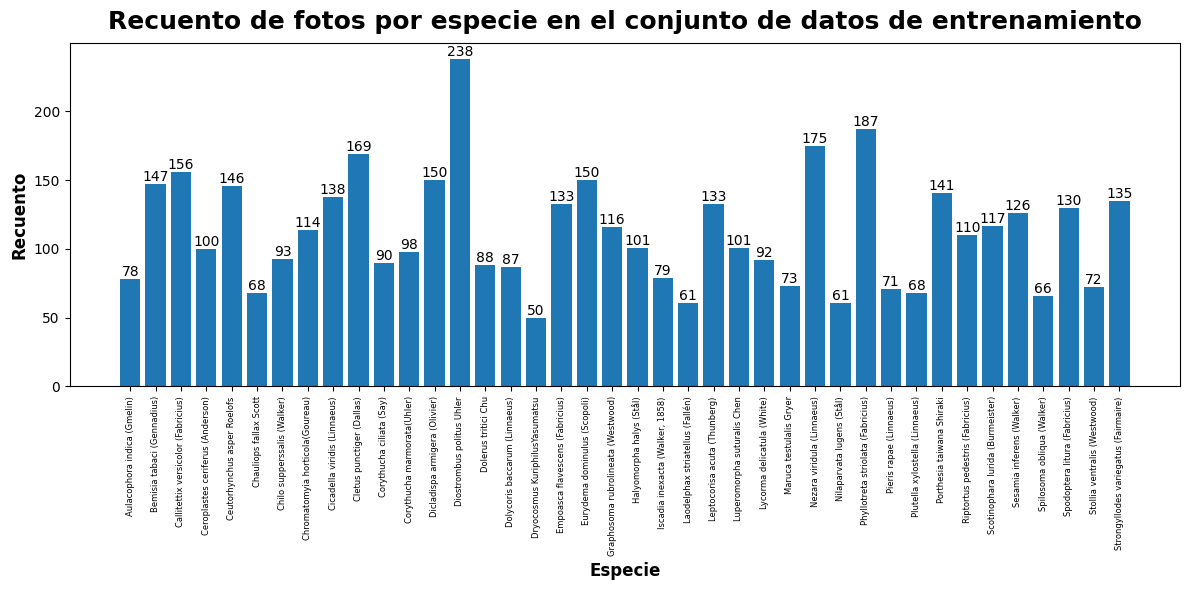

In [15]:
species_count = {species: 0 for species in class_names}

for _, labels in dataset:
    for label in labels:
        species_count[class_names[label]] += 1


# Obtén las especies y los recuentos de fotos
species = list(species_count.keys())
counts = list(species_count.values())

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Crea el gráfico de barras
bp = ax.bar(species, counts)

# Rota las etiquetas del eje x
ax.set_xticklabels(species, rotation=90, size=6)

# Establece el título y las etiquetas de los ejes
ax.set_title('Recuento de fotos por especie en el conjunto de datos de entrenamiento')
ax.set_xlabel('Especie')
ax.set_ylabel('Recuento')

# Añade las etiquetas de recuento en la parte superior de las barras
for rect in bp:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(height),
            ha='center', va='bottom')


plt.tight_layout()
plt.show()

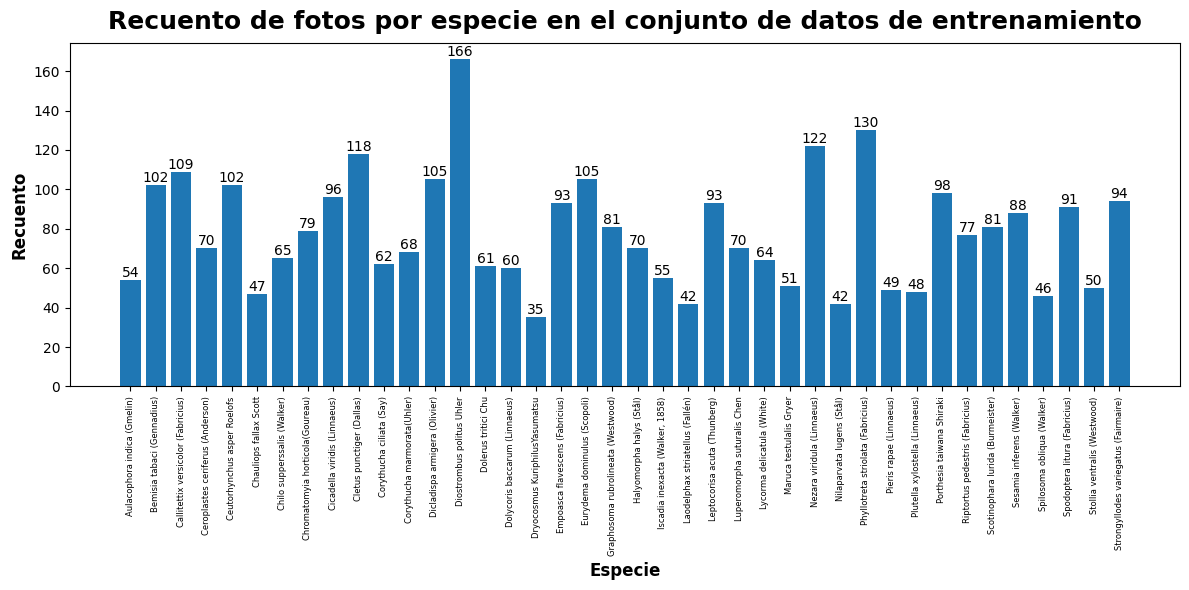

In [16]:
species_count = {species: 0 for species in class_names}

for _, labels in train_dataset:
    for label in labels:
        species_count[class_names[label]] += 1

# Obtén las especies y los recuentos de fotos
species = list(species_count.keys())
counts = list(species_count.values())

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Crea el gráfico de barras
bp = ax.bar(species, counts)

# Rota las etiquetas del eje x
ax.set_xticklabels(species, rotation=90, size=6)

# Establece el título y las etiquetas de los ejes
ax.set_title('Recuento de fotos por especie en el conjunto de datos de entrenamiento')
ax.set_xlabel('Especie')
ax.set_ylabel('Recuento')

# Añade las etiquetas de recuento en la parte superior de las barras
for rect in bp:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(height),
            ha='center', va='bottom')

# Muestra el gráfico
plt.tight_layout()
plt.show()

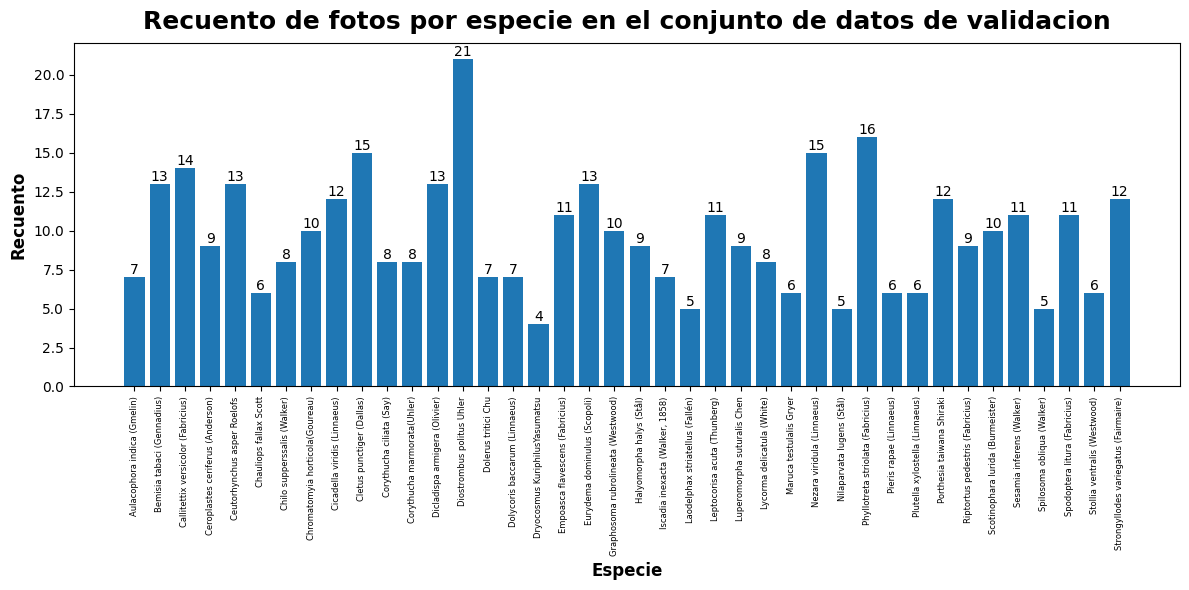

In [17]:


species_count = {species: 0 for species in class_names}

for _, labels in val_dataset:
    for label in labels:
        species_count[class_names[label]] += 1

# Obtén las especies y los recuentos de fotos
species = list(species_count.keys())
counts = list(species_count.values())

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Crea el gráfico de barras
bp = ax.bar(species, counts)

# Rota las etiquetas del eje x
ax.set_xticklabels(species, rotation=90, size=6)

# Establece el título y las etiquetas de los ejes
ax.set_title('Recuento de fotos por especie en el conjunto de datos de validacion')
ax.set_xlabel('Especie')
ax.set_ylabel('Recuento')

# Añade las etiquetas de recuento en la parte superior de las barras
for rect in bp:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(height),
            ha='center', va='bottom')

# Muestra el gráfico
plt.tight_layout()
plt.show()


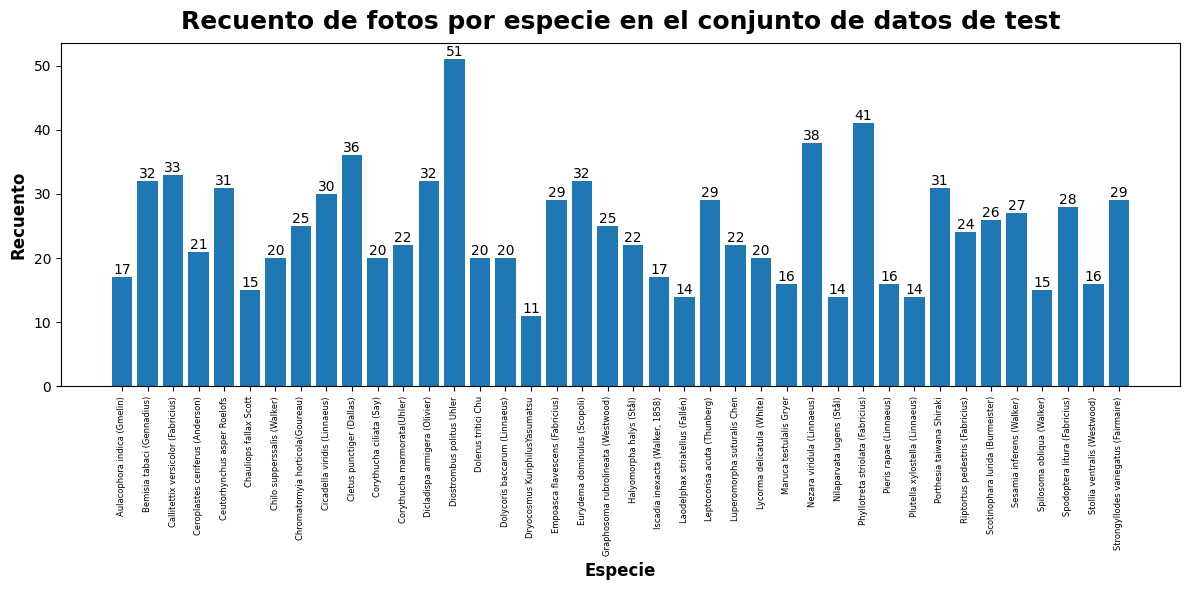

In [18]:
species_count = {species: 0 for species in class_names}

for _, labels in test_dataset:
    for label in labels:
        species_count[class_names[label]] += 1

# Obtén las especies y los recuentos de fotos
species = list(species_count.keys())
counts = list(species_count.values())

# Crea la figura y el eje
fig, ax = plt.subplots(figsize=(12, 6))

# Crea el gráfico de barras
bp = ax.bar(species, counts)

# Rota las etiquetas del eje x
ax.set_xticklabels(species, rotation=90, size=6)

# Establece el título y las etiquetas de los ejes
ax.set_title('Recuento de fotos por especie en el conjunto de datos de test')
ax.set_xlabel('Especie')
ax.set_ylabel('Recuento')

# Añade las etiquetas de recuento en la parte superior de las barras
for rect in bp:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, str(height),
            ha='center', va='bottom')

# Muestra el gráfico
plt.tight_layout()
plt.show()

In [19]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data

    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case,
                                     # these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is
    # the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return class_names[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(class_names[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                class_names[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image.astype(int))
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize/1.5) if not red else int(titlesize/2.65), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]

    # auto-squaring: this will drop data that does not fit into square
    # or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows

    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))

    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else class_names[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)

    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


In [20]:
ds_iter = iter(train_dataset.unbatch().batch(20))

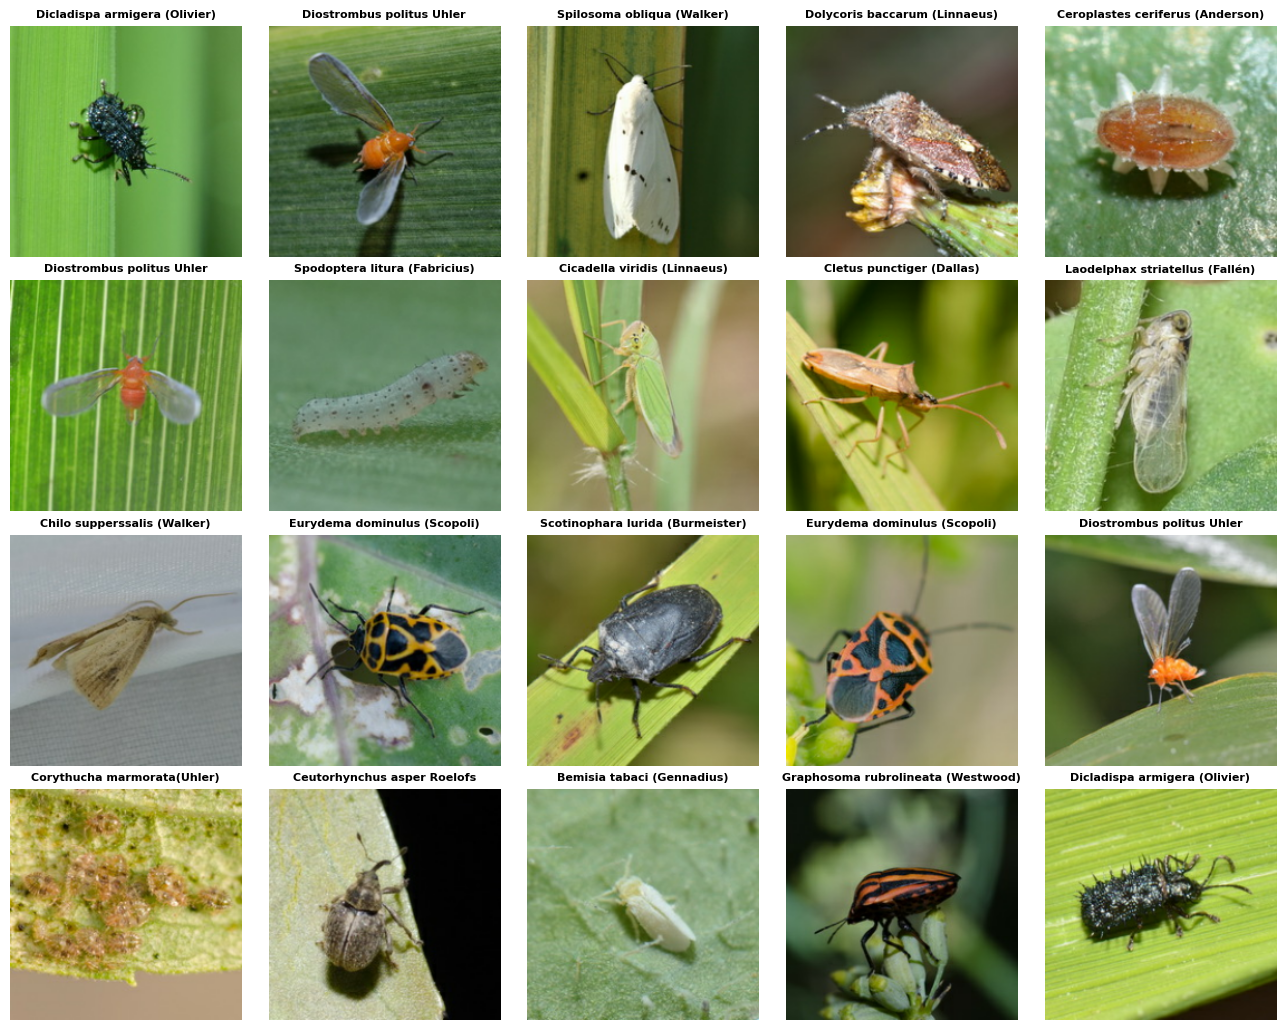

In [21]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

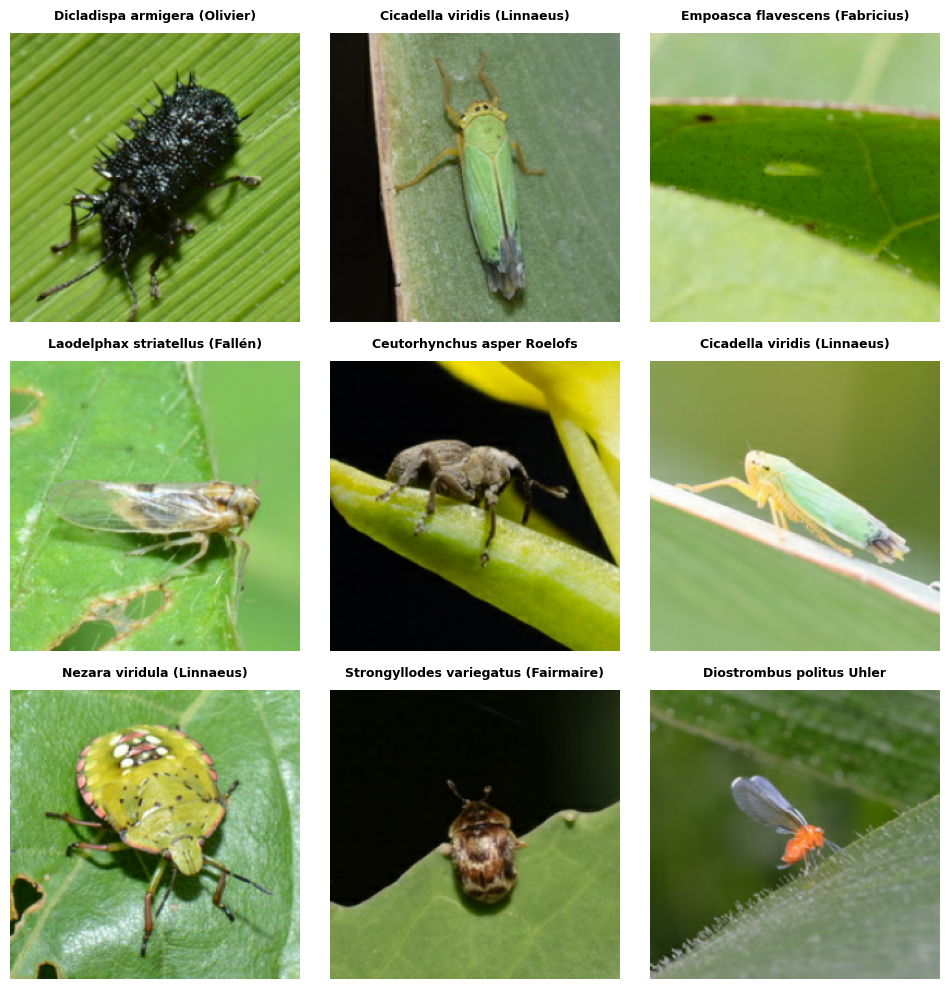

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]], fontsize = 9)
    plt.axis("off")


In [23]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


Usar aumento de datos

In [24]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


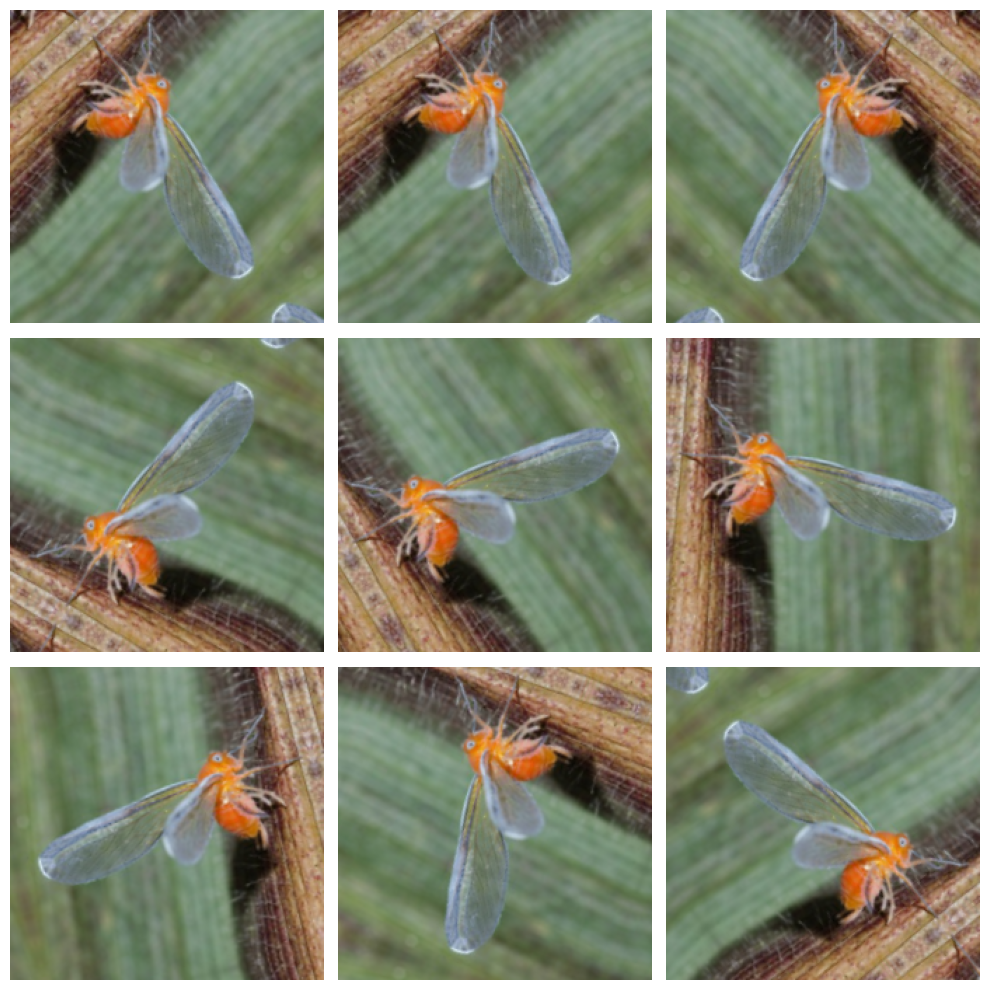

In [25]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [26]:
initial_epochs = 100

Learning rate schedule: 1e-05 to 5e-05 to 1e-05


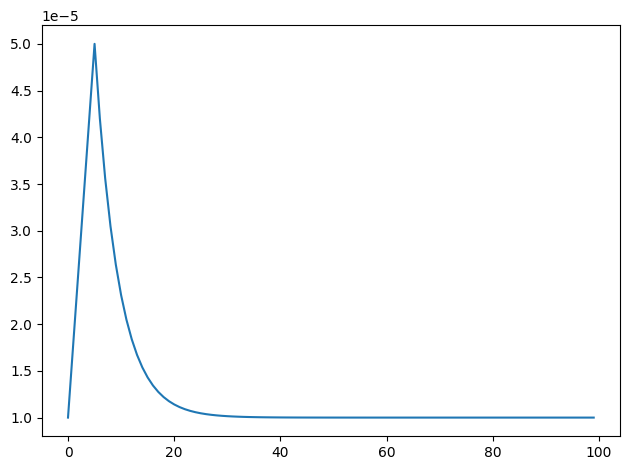

In [27]:
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(initial_epochs)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience = 10,
    min_delta = 0.001,
    restore_best_weights = True,
)

In [29]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [30]:
IMG_SHAPE = IMG_SIZE + (3,)
pretrained_base = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')



In [31]:
pretrained_base.trainable = False

In [32]:

model = keras.Sequential([
    pretrained_base,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

In [33]:
base_learning_rate = 0.0001
model.compile(optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [34]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping],)


Epoch 1/100
25/25 [==============================] - 11s 343ms/step - loss: 9.6548 - sparse_categorical_accuracy: 0.3230 - val_loss: 8.9312 - val_sparse_categorical_accuracy: 0.3067
Epoch 2/100
25/25 [==============================] - 8s 305ms/step - loss: 6.9598 - sparse_categorical_accuracy: 0.6512 - val_loss: 7.3326 - val_sparse_categorical_accuracy: 0.3686
Epoch 3/100
25/25 [==============================] - 8s 311ms/step - loss: 5.4115 - sparse_categorical_accuracy: 0.7751 - val_loss: 5.9905 - val_sparse_categorical_accuracy: 0.4897
Epoch 4/100
25/25 [==============================] - 8s 303ms/step - loss: 4.2269 - sparse_categorical_accuracy: 0.8356 - val_loss: 4.9326 - val_sparse_categorical_accuracy: 0.5876
Epoch 5/100
25/25 [==============================] - 8s 305ms/step - loss: 3.3067 - sparse_categorical_accuracy: 0.8853 - val_loss: 4.1496 - val_sparse_categorical_accuracy: 0.6134
Epoch 6/100
25/25 [==============================] - 8s 302ms/step - loss: 2.6313 - sparse_cat

In [35]:
model.save('species_recognition_model_mobilenet_v2.h5')

<Axes: >

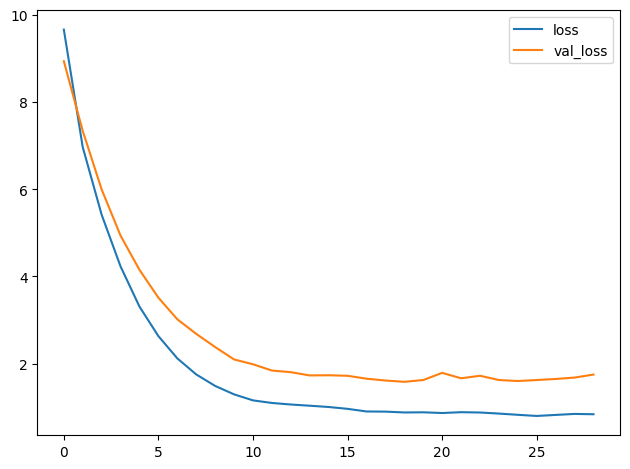

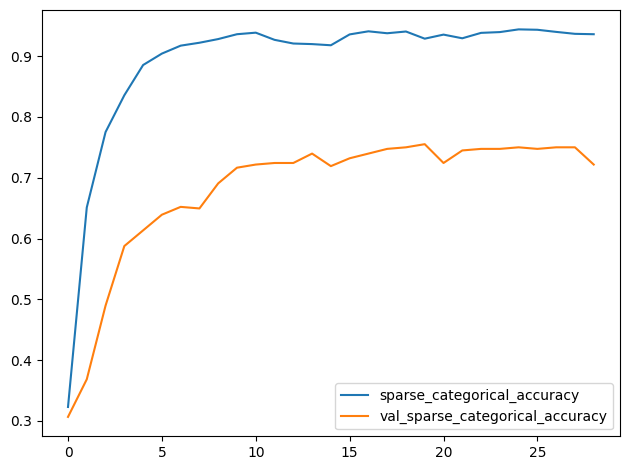

In [36]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss', 'val_loss']].plot()
history_frame.loc[:,['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()


In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                      

In [38]:
pretrained_base.trainable = True

In [39]:
print("Number of layers in the base model: ", len(pretrained_base.layers))
part_congelada = len(pretrained_base.layers)*0.69
print("Number of layers in the base model  congelados: ", len(part_congelada))
for layer in pretrained_base.layers[:int(part_congelada)]:
  layer.trainable = False



Number of layers in the base model:  154


In [40]:
base_learning_rate = 0.0001
model.compile(optimizer='RMSprop',
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'],
)

In [41]:
epochs_cont = initial_epochs + 50

In [42]:
history = model.fit(train_dataset,
                    initial_epoch = history.epoch[-1],
                    epochs=epochs_cont,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping],)

Epoch 29/150
25/25 [==============================] - 15s 476ms/step - loss: 2.7556 - sparse_categorical_accuracy: 0.5801 - val_loss: 16.1030 - val_sparse_categorical_accuracy: 0.0438
Epoch 30/150
25/25 [==============================] - 11s 441ms/step - loss: 1.1876 - sparse_categorical_accuracy: 0.8659 - val_loss: 11.6823 - val_sparse_categorical_accuracy: 0.0954
Epoch 31/150
25/25 [==============================] - 11s 432ms/step - loss: 1.0277 - sparse_categorical_accuracy: 0.9044 - val_loss: 15.9329 - val_sparse_categorical_accuracy: 0.0670
Epoch 32/150
25/25 [==============================] - 11s 429ms/step - loss: 0.9242 - sparse_categorical_accuracy: 0.9133 - val_loss: 17.0421 - val_sparse_categorical_accuracy: 0.1057
Epoch 33/150
25/25 [==============================] - 11s 429ms/step - loss: 0.7542 - sparse_categorical_accuracy: 0.9309 - val_loss: 18.9156 - val_sparse_categorical_accuracy: 0.1057
Epoch 34/150
25/25 [==============================] - 11s 428ms/step - loss: 0.6

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss', 'val_loss']].plot()
history_frame.loc[:,['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()


In [ ]:

batch = iter(test_dataset.unbatch().batch(50))

In [ ]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)

In [ ]:
loss, accuracy = model.evaluate(test_dataset)


In [ ]:
print('Test accuracy :', accuracy)
print('Test loss :', loss)



In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [ ]:
def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Blues')
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec
    # files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [ ]:
true_labels = []
predicted_labels = []

for image, label in test_dataset:
    true_labels.append(label)
    predicted_probs = model.predict(image)  # Realiza la predicción utilizando tu modelo
    predicted_label = np.argmax(predicted_probs, axis=1)
    predicted_labels.append(predicted_label)

true_labels = np.concatenate(true_labels)
predicted_labels = np.concatenate(predicted_labels)
#cmat = confusion_matrix(true_labels, predicted_labels, normalize='all')
cmat = confusion_matrix(true_labels, predicted_labels)


In [ ]:
print(cmat)

In [ ]:
fig, ax = plt.subplots(figsize=(22,22))

# Crea el mapa de calor de la matriz de confusión normalizada
sns.heatmap(cmat, annot=True, cmap='Blues', fmt='.0f', xticklabels=class_names, yticklabels=class_names, ax=ax)

# Establece el título y las etiquetas de los ejes
ax.set_title('Matriz de Confusión Normalizada')
ax.set_xlabel('Etiqueta Predicha')
ax.set_ylabel('Etiqueta Verdadera')

# Muestra la figura
plt.show()

In [ ]:
score = f1_score(true_labels, predicted_labels, labels=labels, average='macro')
precision = precision_score(true_labels, predicted_labels, labels=labels, average='macro')
recall = recall_score(true_labels, predicted_labels, labels=labels, average='macro')
display_confusion_matrix(cmat, score, precision, recall)